# Investigation on the Annual Percentage Rate of Prosper Loans
## by Pedro Cruz

## Investigation Overview

> In this investigation, I wanted to take a closer look on the the annual percentage rate for the loan ("BorrowerAPR" variable), to understand which carachteristcs affect it. The main focus was on its relation with the borrower's stated income ("StatedMonthlyIncome"  and with the "ProsperScore" ("a custom risk score built using historical Prosper data" as explained in the data dictionary).

## Dataset Overview

> The Prosper Loans dataset contains information about 113,937 loan listings from Prosper, a marketplace for peer-to-peer loans.  
The dataset have 81 variables.  
Due to quality problems, 1,481 rows (1,456 duplicated rows and 25 loans with nans in the "BorrowerAPR" variable) were removed from the analysis.


In [103]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [104]:
def df_feature_engineering(df):
    """ all the engineered features
    """
    # as the income values are high the numbers got truncated, so I will create a new column with the income in thousands of USD
    df['StatedMonthlyIncome_USD(000)'] = df['StatedMonthlyIncome'].apply(lambda x: round(x/1000, 0))

    # create boolean ccolumns for the combination of each boolean variable ('IncomeVerifiable', 'CurrentlyInGroup', 'IsBorrowerHomeowner')
    df['IncomeVerifiable and InGroup'] = df['IncomeVerifiable'] + df['CurrentlyInGroup']
    df['IncomeVerifiable and IsHomeowner'] = df['IncomeVerifiable'] + df['IsBorrowerHomeowner']
    df['InGroup and IsHomeowner'] = df['CurrentlyInGroup'] + df['IsBorrowerHomeowner']
    df['IncomeVerifiable InGroup and IsHomeowner'] = df['IncomeVerifiable'] + df['CurrentlyInGroup'] + df['IsBorrowerHomeowner']
    return df

def df_data_cleanning(df):
    """
    Function with all the steps in the data cleaning
    section of the Part I (not used in Part I, as
    there I wanted to clean with the define/code/test
    framework.)
    """
    # 1. DROP NANs FROM THE 'BorrowerAPR'
    df = df[~df['BorrowerAPR'].isna()]

    # 2. REMOVE DUPLICATES
    # get the mean of the ProsperScore for each LoanKey
    df_adj_score = df[df['LoanKey'].duplicated(keep=False)][['LoanKey','ProsperScore']]\
    .groupby('LoanKey').mean()\
    .reset_index()

    # rename columns
    df_adj_score.columns = ['LoanKey', 'ProsperScore_adjusted']

    # round the adjusted score to the nearest integer (rounding lambda here: https://stackoverflow.com/a/68060638)
    # use the min function to lower the cases with 11s to 10s
    df_adj_score['ProsperScore_adjusted'] = df_adj_score['ProsperScore_adjusted'].apply(lambda x: min(10,int(x+0.5)))

    # drop the duplicates from the df, leaving only one row
    # for each LoanKey.
    # irrelevant which row will be kept, as the new ProsperScore
    # will be the one calculated in the cell above.

    df.drop_duplicates(subset=['LoanKey'], inplace=True)

    # merge the datasets, creating the column "ProsperScore_adjusted" in the df
    df = pd.merge(left=df, right=df_adj_score, on='LoanKey', how='left')

    # update the "ProsperScore" column, keepping the value of ProsperScore where there is no ProsperScore_adjusted
    df['ProsperScore'] = np.where(df['ProsperScore_adjusted'].isna(),df['ProsperScore'], df['ProsperScore_adjusted'])

    # drop the extra column
    df.drop(columns='ProsperScore_adjusted', inplace=True)

    # 3 HANDLE INVALID VALUES IN THE ProsperScore
    df['ProsperScore'].fillna(1, inplace=True)
    df['ProsperScore'].replace(to_replace=11, value=10, inplace=True)

    # 4 CONVERT CATEGORICAL VARIABLES
    # first, create the ProsperScore numeric variable (for scatterplots)
    df['ProsperScore (num)'] = df['ProsperScore'].astype(int)

    # aux dictionary
    cat_columns = {'ProsperRating (Alpha)': ['HR','E','D','C','B','A','AA'],
                   'ProsperRating (numeric)': [0,1, 2, 3, 4, 5,6,7],
                   'ProsperScore': [1,2,3,4,5,6,7,8,9,10],
                   'IncomeRange': ['Not displayed','Not employed','$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999','$75,000-99,999','$100,000+']
                  }
    
    # change the types of the categorical columns
    df = to_ordered_category(df, cat_columns)

    # 5 CONVERT DATETIME VARIABLES
    date_cols = ['ListingCreationDate','ClosedDate','LoanOriginationDate','DateCreditPulled','FirstRecordedCreditLine']

    for col in date_cols:
        try:
            df[col] = pd.to_datetime(df[col]).dt.to_period('D')
        except:
            pass

    # 6 TRANSLATE LISTING CATEGORY NUMBERS TO ACTUAL CATEGORIES

    listingcat = {0: 'Not Available',
                  1: 'Debt Consolidation',
                  2: 'Home Improvement',
                  3: 'Business',
                  4: 'Personal Loan',
                  5: 'Student Use',
                  6: 'Auto',
                  7: 'Other',
                  8: 'Baby&Adoption',
                  9: 'Boat',
                  10: 'Cosmetic Procedure',
                  11: 'Engagement Ring',
                  12: 'Green Loans',
                  13: 'Household Expenses',
                  14: 'Large Purchases',
                  15: 'Medical/Dental',
                  16: 'Motorcycle',
                  17: 'RV',
                  18: 'Taxes',
                  19: 'Vacation',
                  20: 'Wedding Loans'
                 }
    df['ListingCategory'] = df['ListingCategory (numeric)'].replace(listingcat)
    return df

def proportion_cat_plot(df, category_column, prop_increment=0.05, figsize=[12,6]):
    """
    Creates a horizontal bar chart with proportions of a category variable (category_column),
    from a given dataset (df).
    """
    cat_counts = df[category_column].value_counts()
    cat_order = cat_counts.index

    # 1. Compute largest proportion
    n_cat = cat_counts.sum()
    max_cat_count = cat_counts[0]
    max_prop = max_cat_count / n_cat

    # 2. establish tick locations
    tick_props = np.arange(0, max_prop+prop_increment, prop_increment)

    # 3. establish tick names
    tick_names = ['{:0.0%}'.format(v) for v in tick_props]

    # create plot
    base_color = sb.color_palette()[0]
    plt.figure(figsize = figsize)
    sb.countplot(data = df, y = category_column, color = base_color, order = cat_order)
    plt.xticks(tick_props * n_cat, tick_names)
    plt.xlabel('proportion')
    plt.title(category_column+' Proportions');
    
def to_ordered_category(df, ordinal_var_dict):
    """
    # using the same idea found in the diamonds example project
    
    Changes a column(s) format(s) in a given df to categorical, Using a
    dict of {key: list}, where key is a column that exists in the
    df, and list is a list of ordered categories for the values
    in that column.
    """
    for var in ordinal_var_dict:
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        df[var] = df[var].astype(ordered_var)
    return df

def hist_with_aux_lines(data, range=None, binsize=0.01, ticksize=0.05, log_scale=False, show_mean=True, show_median=True, show_mode=True, format='%', legend_precision=2):
    """
    Creates a histogram for a series (data) with optional vertical lines for mean,
    median and mode.
    The fuction also acepts a range for the data and can plot in standard or
    logarithmic scale.
    
    Credits:
    # vertical line(s) idea here: https://stackoverflow.com/a/52961228
    # legend for vertical line(s) here: https://stackoverflow.com/a/30282684
    # filter series with lambda function here: https://stackoverflow.com/a/38258528
    """    
    
    if range:
        series = data[lambda x: ((x>range[0])&(x<=range[1]))]
    else:
        series = data
    
    # options for bins and x-axis labels, according to
    # the varible log_scale
    
    binsize = binsize
    ticksize = ticksize
    min_value = round(series.min(),2)
    max_value = series.max()

    if log_scale:
        min_logvalue = round(np.log10(min_value),2)
        max_logvalue = np.log10(max_value)
        bins = 10 ** np.arange(min_logvalue, max_logvalue+binsize, binsize)
        ticks = [0.01, 0.02, 0.05, 0.1, 0.2, max_value]
    else:
        bins = np.arange(min_value, max_value+binsize, binsize)
        ticks = np.arange(min_value, max_value, ticksize)
    
    # CLEAN THE TICKS LIST
    # this list comprehension will
    #  - return all the values between the range min_value - max_value.
    #  - return the min_value everytime a number falls outside the range
    ticks = [x if x >= min_value <=max_value else min_value for x in ticks]

    # as the ticks list may contain multiple itens with the min_value, here I
    # use the set() function, that returns only the unique values from a list.
    # Finally, convert it again to list and sort.
    ticks = list(set(ticks))
    ticks.sort()
    
    # format of the x axis labels, according to how many
    # points there is to plot.
    if format=='%':
        if len(ticks) > 10:
            labels_format = '{:0.0%}'
            legend_format = '{:0.'+str(legend_precision)+'%}'
        else:
            labels_format = '{:0.2%}'
            legend_format = '{:0.'+str(legend_precision)+'%}'
    else:
        # not percentage. Convert to float
        ticks = 100 * ticks
        if len(ticks) > 10:
            labels_format = '{:0.0f}'
            legend_format = '{:0.'+str(legend_precision)+'f}'
        else:
            labels_format = '{:0.2f}'
            legend_format = '{:0.'+str(legend_precision)+'f}'
    
    tick_labels = [labels_format.format(v) for v in ticks]

    # create the plot
    plt.figure(figsize=(20, 7))
    plt.hist(x = series, bins = bins)
    if log_scale:
        plt.xscale('log')
        plt.xlabel('x-axis limits are changed, and scaled to log-type')
        plt.title('log distribution of the '+series.name+' variable')
    else:
        plt.xlabel(series.name+'('+format+')')
        # plt.ylabel("count")
        plt.title('distribution of the '+series.name+' variable')        
    
    # Apply the custom x-ticks
    plt.xticks(ticks, tick_labels)

    # PROBLEM (bug?)
    # some tick points kept showing scientific notation, despite the
    # use of xticks().
    # Latter discovered that the problem was the "minor ticks"
    # solution here: https://stackoverflow.com/a/10781270
    plt.minorticks_off()

    if show_mean or show_median or show_mode:
        min_ylim, max_ylim = plt.ylim()

    if show_mean:
        mean_rate = series.mean()
        plt.axvline(mean_rate, color='red', linestyle='-', linewidth=2, label='Mean: '+legend_format.format(mean_rate))
        
    if show_median:
        median_rate = series.median()
        plt.axvline(median_rate, color='orange', linestyle='-', linewidth=2, label='Median: '+legend_format.format(median_rate))
        
    if show_mode:
        # mode() returns a series, so the [0]
        mode_rate = series.mode()[0]
        plt.axvline(mode_rate, color='green', linestyle='-', linewidth=2, label='Mode: '+legend_format.format(mode_rate))
    if show_mean or show_median or show_mode:
        plt.legend(loc='upper right')
    plt.show()
    
    # CUSTOM FUNCTION FOR MULTIVARIATE PLOTS

def regplot_three_var(df, x, y, third_var, markers=[[True, 'o'],[False, 's']]):
    """
    Custom function for regplots with three variables and correlation
    shown in the legend.
    """
    
    cat_markers = markers
    legend_list = []

    fig, ax = plt.subplots(figsize=[15,8])
    for cat, marker in cat_markers:
        df_cat = df[df[third_var] == cat]
        sb.regplot(ax=ax, data=df_cat, x=x, y=y, x_jitter=0.1, y_jitter=0.01, scatter_kws={'alpha':0.30}, truncate=False, marker=marker)\
    .set(title=x+' vs '+y+' | color by '+third_var)

        legend_list.append(str(cat)+' (corr: '+str(round(df_cat[[x, y]].corr().loc[x, y],2))+')')

    plt.legend(legend_list)

    plt.show();
    
def income_percentile_filter(df, percentile):
    """
    custom function to filter the df on a
    specific percentile of the stated monthly
    income.
    """
    mask = df['StatedMonthlyIncome_USD(000)']<=np.percentile(df['StatedMonthlyIncome_USD(000)'], percentile)
    return df[mask]

In [105]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

# Data Cleaning (all steps)
df_clean = df_data_cleanning(df)
# feature engineering (all steps)
df_clean = df_feature_engineering(df_clean)

## Distribution of Annual Percentage Rates (BorrowerAPR)

The annual percentage rate  has a very large range, from very low rates, below 6% a year, up to 51% a year. The distribution, ploted on a standard scale seems roughly normal, with a peak spike around 35%. Also, the distribution is right skewed, suggesting outliers above the 40% annual rate.

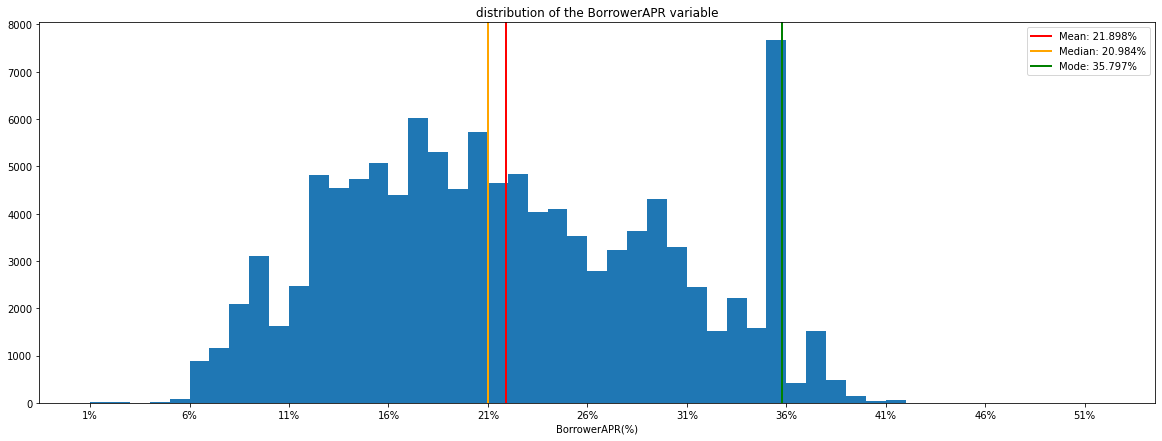

In [106]:
hist_with_aux_lines(df_clean['BorrowerAPR'], binsize=0.01, ticksize=0.05, legend_precision=3)

## Zoom in the peak around 35%

> Zooming in the 35% to 36% range, is possible to see that the peak around 35% saw on the distribution in fact are the loans with a 35.797% rate, which also happens to be the mode of the whole series.
>
> The quantity of loans with this same rate (3,672 loans, or 3.22% of all loans) suggest that this is a standard rate.

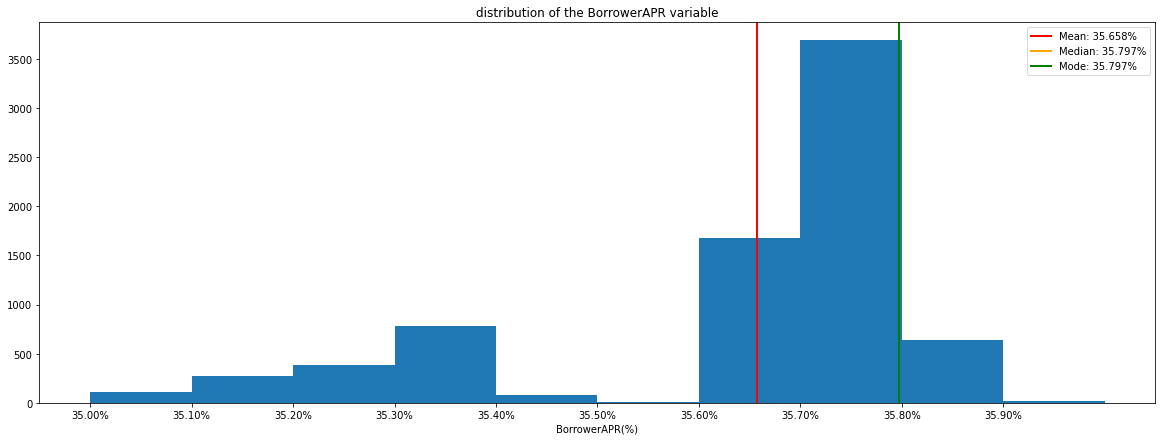

In [107]:
# zoom in the 35 to 36% range
hist_with_aux_lines(data=df_clean['BorrowerAPR'], range=(0.35, 0.36), binsize=0.001, ticksize=0.001, legend_precision=3)

## Distribution of StatedMonthlyIncome

The distribution for the "StatedMonthlyIncome" has a large tail to the right, suggesting strong outliers to the right.

In fact, the range for this variable goes from 0 to 1.750 k USD, while the 99.9% percentile is only 44 k USD.

The distribution, even limited by the 99.9% percentile, is highly skewed to the right.

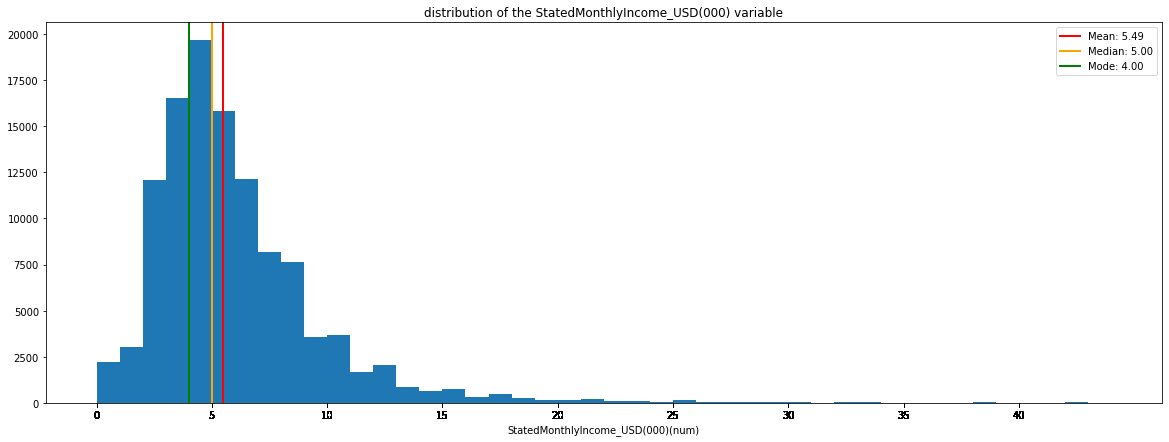

In [108]:
# to plot the histogram, it is necessary to limit the range, as there is a huge tail to the right,
# Considering this, I Decided to use the 99.9% percentile, which is 44k.

hist_with_aux_lines(data=income_percentile_filter(df_clean,99.9)['StatedMonthlyIncome_USD(000)'], binsize=1, ticksize=5, format='num')

## BorrowerAPR vs Monthly Income When The Income Is Verifiable

Despite the very low correlation between StatedMonthlyIncome and BorrowerAPR (-0.16 and -0.06 for verifiable and not verifiable income, respectvely), it is possible to see that a higher income, when verifiable, tends to decrease the APR faster than when not verifiable.

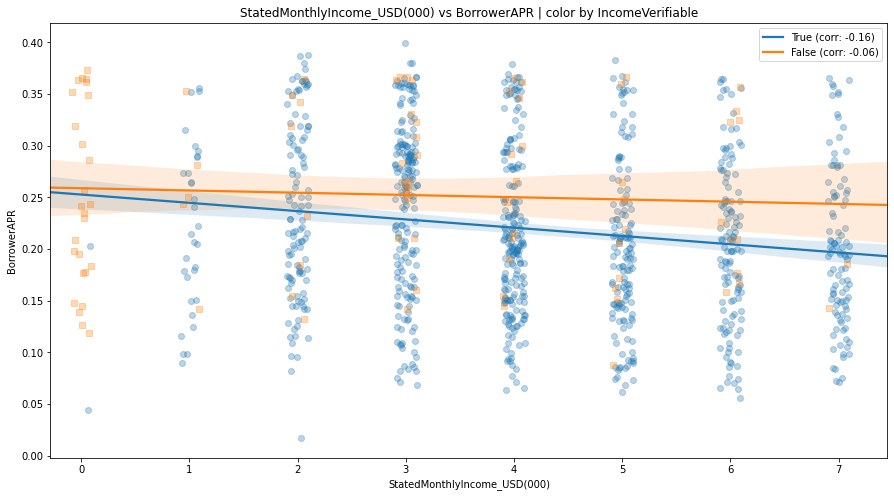

In [109]:
# SAMPLE FOR THE MULTIVARIATE PLOTS

# as the StatedMonthlyIncome has a long right tail, I will limit the
# data to the 75 percentile (higher numbers make this plot too gibberish)

# Also, I'll sample 1000 loans, so the resulting plot is clearer

# seed number for reproducibility
seed = 30
df_sample = income_percentile_filter(df_clean,75).sample(n=1000, replace=False, random_state=seed)

regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='IncomeVerifiable')